# Generating a synthetic disrepancy dataset

Here we go through the process of generating the synthetic discrepancy dataset.

The results will be stored in: `DIR_DATA/discrepancy_dataset/dataset_name/variant_name`

We provide the generated discrepancy dataset used to train our discrepancy network, so there is no need to re-generate it.
It should be located in `DIR_DATA/discrepancy_dataset/cityscapes/051X_semGT__fakeSwapFgd__genNoSty` and can be downloaded from the project page.

The generation process is non-deterministic as it choses random instances and random classes.


In [1]:
# %run -i env_default.py
%run -i src/notebook_base_light.py

## Experiment class

First we create a new Experiment class and its associated config. The `gen_name` entry is the name of the discrepancy dataset variant: here we choose a new name.

```python
gen_name = 'my_discrepancy_variant',
swap_fraction = 0.33, # random fraction of object instances which get altered (default is 0.5)
```

In [2]:
from src.a05_differences.experiments import Exp0521_SwapFgd_ImgAndLabelsVsGen_semGT
from src.pipeline.config import add_experiment

class Exp0551_NewDiscrepancyVariant(Exp0521_SwapFgd_ImgAndLabelsVsGen_semGT):
	cfg = add_experiment(Exp0521_SwapFgd_ImgAndLabelsVsGen_semGT.cfg,
		name = '0551_NewDiscrepancyVariant',
		gen_name = 'my_discrepancy_variant',
		gen_img_ext = '.webp', # better compression
		swap_fraction = 0.75, # instead of default 0.5
    )

exp = Exp0551_NewDiscrepancyVariant()

In [3]:
# Load the Cityscapes dataset
exp.init_default_datasets()

# they are now available here:
exp.datasets['train']

Cityscapes: found images in .webp format
Discovered 2975 frames - DatasetCityscapesSmall(2975 frames, /cvlabsrc1/cvlab/dataset_Cityscapes/1024x512, s=train)
Cityscapes: found images in .webp format
Discovered 2975 frames - DatasetCityscapesSmall(2975 frames, /cvlabsrc1/cvlab/dataset_Cityscapes/1024x512, s=train)
Cityscapes: found images in .webp format
Discovered 500 frames - DatasetCityscapesSmall(500 frames, /cvlabsrc1/cvlab/dataset_Cityscapes/1024x512, s=val)
Cityscapes: found images in .webp format
Discovered 500 frames - DatasetCityscapesSmall(500 frames, /cvlabsrc1/cvlab/dataset_Cityscapes/1024x512, s=val)


DatasetCityscapesSmall(2975 frames, /cvlabsrc1/cvlab/dataset_Cityscapes/1024x512, s=train)

## Construct the pipeline

The steps involved in generating the dataset are shown in `exp.discrepancy_dataset_init_pipeline`. 

The object label substitution is done by the functions `tr_synthetic_swapFgd_labels`, `tr_swap_labels` located in [src/a05_differences/transforms.py](src/a05_differences/transforms.py). 
The chosen function is stored in `exp.synthetic_mod` and can be overwritten if needed.

In [7]:
exp.discrepancy_dataset_init_pipeline(write_orig_label=True)

In [5]:
exp.discrepancy_dataset_init_pipeline??

Signature:
exp.discrepancy_dataset_init_pipeline(
    use_gt_labels=True,
    write_orig_label=False,
)
Source:   
        def discrepancy_dataset_init_pipeline(self, use_gt_labels=True, write_orig_label=False):
                """
                @param use_gt_labels: True: the starting labels which we will be altering are the GT semantics of Cityscapes
                        False: Load starting labels from ch_labelsPred
                """
                self.pix2pix = Pix2PixHD_Generator(self.cfg['pix2pix_variant'])

                if use_gt_labels:
                        self.tr_load_correct_labels = TrsChain(
                                # load cityscapes labels and instances
                                TrChannelLoad('labels_source', 'labels_source'),
                                TrChannelLoad('instances', 'instances'),
                                # convert to trainIDs
                                TrSemSegLabelTranslation(fields=dict(labels_source='pred_label

## Test frame
Visualization of the process on an example frame.

| ----- image --- | --- gen_image  -----|  
| original labels - | - altered labels - | - disrepancy mask |



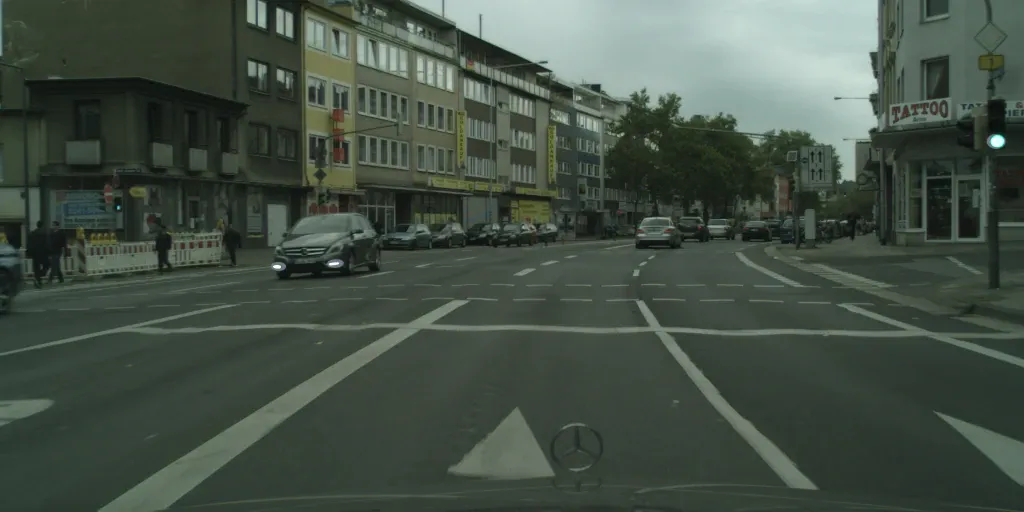
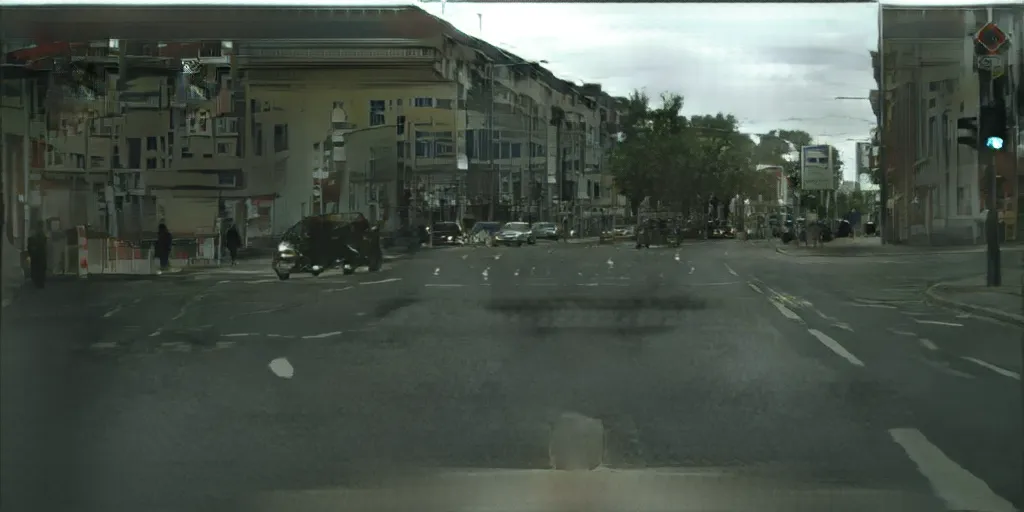
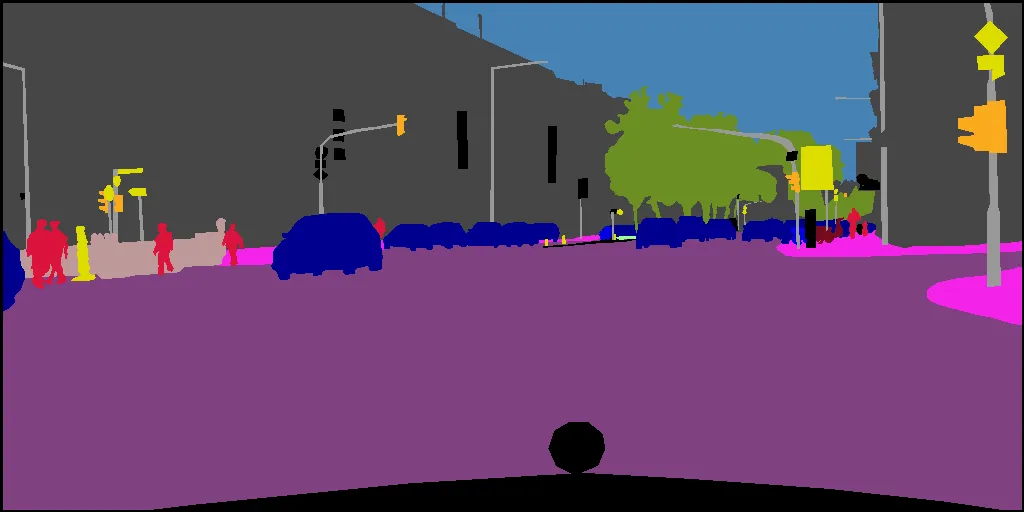
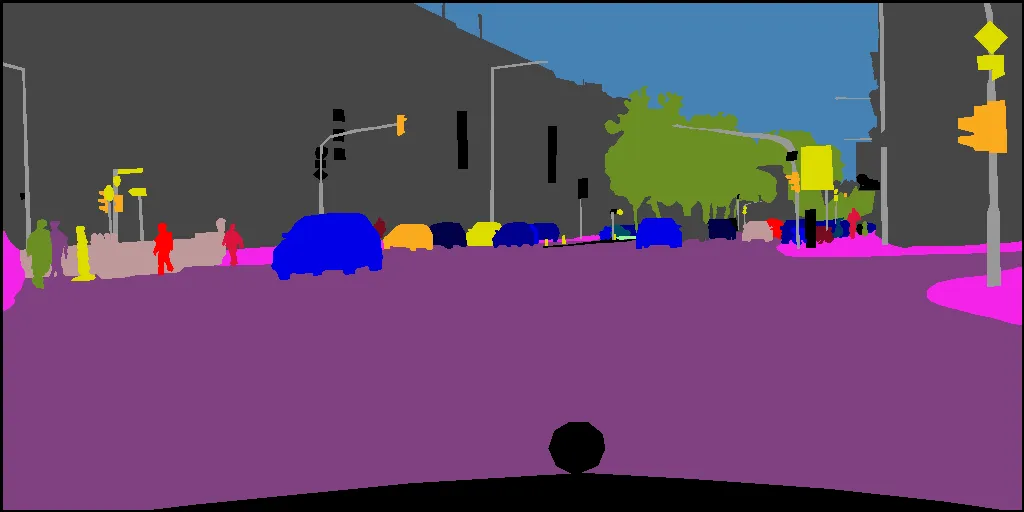
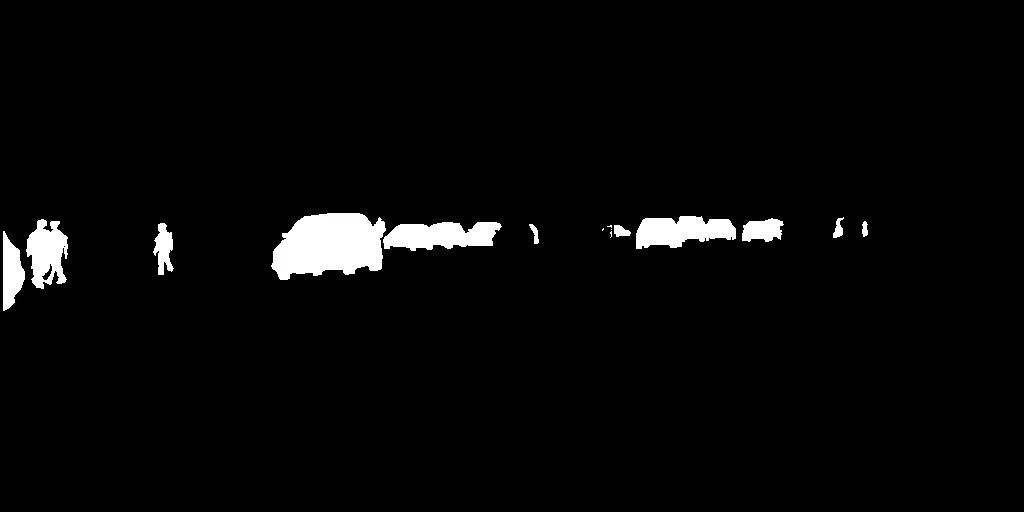

In [9]:
dset = exp.datasets['train']
# disable default loading
dset.set_channels_enabled()
# run pipeline
fr = dset[4]
fr.apply(exp.tr_synthetic_and_show)

In [10]:
# the same process but write to a file
fr.apply(exp.tr_synthetic_and_save)

## Generate whole set

In [ ]:
exp.discrepancy_dataset_generate(dsets=exp.datasets.values())

## Conclusion

Complete code to generate the synthetic dataset.

In [ ]:
from src.a05_differences.experiments import Exp0521_SwapFgd_ImgAndLabelsVsGen_semGT
from src.pipeline.config import add_experiment

class Exp0551_NewDiscrepancyVariant(Exp0521_SwapFgd_ImgAndLabelsVsGen_semGT):
	cfg = add_experiment(Exp0521_SwapFgd_ImgAndLabelsVsGen_semGT.cfg,
		name = '0551_NewDiscrepancyVariant',
		gen_name = 'my_discrepancy_variant',
		gen_img_ext = '.webp', # better compression
		swap_fraction = 0.75, # instead of default 0.5
    )

exp = Exp0551_NewDiscrepancyVariant()
exp.init_default_datasets()
exp.discrepancy_dataset_generate(dsets=exp.datasets.values())

## Training

The Experiment class (`src/pipeline/experiment.py`) is used to train the networks:

```python
from src.a05_differences.experiments import MyExperimentVariant
MyExperimentVariant.training_procedure()
```

Weights will be written to `$DIR_EXP/0551_NewDiscrepancyVariant`
Checkpoints are saved every epoch:
* `chk_best.pth` - checkpoint with the lowest loss on eval set
* `chk_last.pth` - checkpoint after the most recent epoch
* `optimizer.pth` - optimizer data (momentum etc) after the most recent epoch
	
The directory will also contain:
* `[date]_log` - predictions for sample evaluation frames indexed by epoch
* `training.log` - logs from the logging module, if the training procedure failed, the exception will be written there

The loss is written to tensorboard, in order to display:

```bash
	tensorboard --logdir $DIR_EXP/0551_NewDiscrepancyVariant
```

In [ ]:
Exp0551_NewDiscrepancyVariant.training_procedure()